<a href="https://colab.research.google.com/github/kniJanjaras/229352-StatisticalLearning/blob/main/Lab11_Fine_Tuning_Reasoning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #11

# Fine-Tuning Qwen3 for Thai Text Reasoning

Today, you will learn how to take a pre-trained Large Language Model (LLM) and specialize it for **Thai text reasoning** using the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT).

We will be using [**Unsloth**](https://docs.unsloth.ai/get-started/all-our-models) to speeds up finetuning and reduces memory usage, making it possible to train in Google Colab.

-ใช้ Unsoult บีบข้อมูลจากโฒเดล 32 บิท เหลือ 4 บิท


If GPUs are not available in your Colab, you might want to try these two alternatives:
1. [Kaggle](https://www.kaggle.com)
2. [lightning.ai](https://lightning.ai)

### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

### Fine-tuning Qwen3 with Unsloth

#### Transformer in Qwen3 vs GPT-2
<img src="https://substackcdn.com/image/fetch/$s_!GGk9!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa8fa602a-aa4d-4526-9252-c2f09dd5de92_1871x1920.png" alt="transformers" width="600"/>

[Source: [Sebastian Raschka](https://magazine.sebastianraschka.com/p/qwen3-from-scratch)]

โหลดโมเดลเข้ามาจาก Unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
)

#### Low-Rank Adaptation (LoRA)
<img src="https://substackcdn.com/image/fetch/$s_!LXL5!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F7ab94b67-4efa-45e2-9a77-3121d6c88c45_1284x364.png" alt="LoRA" width="600"/>

[Source: [Dasha Herrmannova](https://oneminutenlp.com/p/low-rank-adaptation)]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128 (ถ้ายังรันไม่ได้ให้ปรัยค่าrเพื่อให้โมเดลเล็กลง)
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

<a name="Data"></a>
### Data Prep
Use the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT) provided by [iApp Technology](https://iapp.co.th/).

In [ ]:
from datasets import load_dataset
reasoning_dataset = load_dataset("iapp/Thai-R1-Distill-SFT", split = "train")

Let's see the structure of both datasets:

In [ ]:
reasoning_dataset

We now convert the reasoning dataset into conversational format:

In [ ]:
def generate_conversation(examples):
    problems  = examples["problem"]
    solutions = examples["reannotated_assistant_content"]
    conversations = []
    for problem, solution in zip(problems, solutions):
        conversations.append([
            {"role" : "user",      "content" : problem},
            {"role" : "assistant", "content" : solution},
        ])
    return { "conversations": conversations, }

In [ ]:
reasoning_conversations = tokenizer.apply_chat_template(
    reasoning_dataset.map(generate_conversation, batched = True)["conversations"],
    tokenize = False,
)

Let's see the first transformed row:

In [ ]:
reasoning_conversations[0]   # list ของคำตอบ

In [ ]:
print(len(reasoning_conversations)) #จำนวนข้อมูลคำถามและคำตอน10000ชุด

10000


In [ ]:
import pandas as pd

data = pd.Series(reasoning_conversations)
data.name = "text"

from datasets import Dataset
prepared_dataset = Dataset.from_pandas(pd.DataFrame(data))
prepared_dataset = prepared_dataset.shuffle(seed = 3407)  #shuffleข้อมูลก่อนใส่เข้าไปในโมเดล

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [ ]:
import gc
from trl import SFTTrainer, SFTConfig

# Free some memory (clear memoryของGPU4)
gc.collect()
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = prepared_dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2, #ในแต่ละbatchมี2ประโยค
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,  #trainโดยไม่สนในlossfuntion
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 15,  #train15รอบ
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [ ]:
trainer_stats = trainer.train()  #เอาข้อมูลtrain

<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

tokenizer เป็นตัวที่ใช้ในการแบ่งคำ

In [ ]:
FastLanguageModel.for_inference(model)

messages = [
    {"role" : "user", "content" : "จงหาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5"}   # คำถามที่ใช้ test model
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024, # Increase for longer outputs  เปลี่ยนเลขเพิ่มความยาวoutputได้
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
โอเค ฉันต้องหาจำนวนเต็ม x และ y ทั้งหมดที่ทำให้สมการ x² - y² = 5 เป็นจริง ฉันรู้ว่า x² - y² สามารถแยกตัวประกอบได้เป็น (x - y)(x + y) ดังนั้น สมการที่กำหนดจึงกลายเป็น (x - y)(x + y) = 5 ตอนนี้ 5 เป็นจำนวนเฉพาะ ดังนั้น ตัวประกอบของมันจึงเป็น 1 และ 5 หรือ -1 และ -5 ฉันต้องพิจารณาทั้งสองกรณี: กรณี 1: x - y = 1 และ x + y = 5 ฉันสามารถแก้ระบบเหล่านี้เพื่อหา x และ y ได้โดยการเพิ่มสมการทั้งสอง: (x - y) + (x + y) = 1 + 5 → 2x = 6 → x = 3 เมื่อแทนค่า x = 3 ลงในสมการ x - y = 1: 3 - y = 1 → y = 2 ดังนั้น หนึ่งในคำตอบคือ x = 3 และ y = 2 กรณี 2: x - y = -1 และ x + y = -5 ฉันจะแก้ระบบเหล่านี้ได้โดยการเพิ่มสมการทั้งสอง: (x - y) + (x + y) = -1 + (-5) → 2x = -6 → x = -3 เมื่อแทนค่า x = -3 ลงในสมการ x - y = -1: -3 - y = -1 → y = -2 ดังนั้น อีกคำตอบหนึ่งคือ x = -3 และ y = -2 ดังนั้น จำนวนเต็ม x และ y ทั้งหมดที่ทำให้สมการ x² - y² = 5 เป็นจริงคือ (3, 2) และ (-3, -2) ฉันควรตรวจสอบคำตอบเหล่านี้เพื่อให้แน่ใจว่าเป็นไปตามสมการ สำหรับ (3, 2): x² - y² = 3² - 2² = 9 - 4 = 5 สำหรับ (-3, -2): x² - y² = (-3)² 

### Exercise 1: Ask the model a challenging math problem. You may increase the value of `max_new_tokens` if the model's answer is too short. Does the model solve your problem correctly?

In [ ]:
### YOUR CODE HERE ###
FastLanguageModel.for_inference(model)

messages = [
    {"role" : "user", "content" : "จงหาค่าของ (20^(1/2))*20"}   # คำถามที่ใช้ test model
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024, # Increase for longer outputs  เปลี่ยนเลขเพิ่มความยาวoutputได้
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)


<think>
โอเค ฉันต้องหาค่าของ (20^(1/2)) * 20 ได้ไหม ลองดู 20^(1/2) คือรากที่สองของ 20 ซึ่งก็คือประมาณ 4.4721 ดังนั้นเมื่อฉันคูณด้วย 20 ก็จะได้ 4.4721 * 20 ซึ่งก็คือประมาณ 89.442 ดังนั้นคำตอบสุดท้ายคือประมาณ 89.442
</think>

**ขั้นตอน:**  
1. รากที่สองของ 20 คือ \(\sqrt{20}\)  
2. \(\sqrt{20}\) สามารถเขียนใหม่เป็น \(\sqrt{4 \cdot 5}\)  
3. ใช้คุณสมบัติ \(\sqrt{a \cdot b} = \sqrt{a} \cdot \sqrt{b}\): \(\sqrt{4} \cdot \sqrt{5}\)  
4. \(\sqrt{4}\) คือ 2 ดังนั้น \(\sqrt{20} = 2\sqrt{5}\)  
5. คูณด้วย 20: \((2\sqrt{5}) \cdot 20 = 40\sqrt{5}\)  

**คำตอบสุดท้าย:**  
\(\boxed{40\sqrt{5}}\)<|im_end|>


**Answer to Exercise 1**

- คำตอบสุดท้ายของโมเดลออกมาถูกต้อง คือ 89.44  

  (ถามโจทย์คณิต หาค่ารูทของ20 คูณกับ20)

### Visualizing Attention

### Exercise 2: Fill in the ##TODO## part in the `visualize_attention()` function below to calculate the product between the query matrix `Q` and the key matrix `K`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the helper function to perform the rotation
def rotate_half(x):
    """Rotates half the hidden dimensions of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# Define a global dictionary to store the attention matrix
attention_viz_data = {}

def visualize_attention(model, tokenizer, prompt, layer_number):
    """
    Visualizes the QK^T attention matrix for a given prompt and layer,

    Args:
        model: The Unsloth Qwen3 14B model.
        tokenizer: The tokenizer for the model.
        prompt (str): The input text prompt.
        layer_number (int): The decoder layer number to visualize.
    """
    attention_viz_data.clear()

    # 1. Get a reference to the specific attention layer
    try:
        attention_layer = model.base_model.model.model.layers[layer_number].self_attn
    except AttributeError as e:
        print(f"Could not find the specified layer. Please double-check the model architecture path. Error: {e}")
        return

    # 2. Store the original forward method
    original_forward = attention_layer.forward

    def new_forward(self, hidden_states, *args, **kwargs):
        """A new forward method to capture the QK^T matrix."""

        bsz, q_len, _ = hidden_states.size()

        # Project to Q, K
        Q_all_heads = self.q_proj(hidden_states)
        K_all_heads = self.k_proj(hidden_states)

        # Reshape for multi-head attention. Note the different head counts.
        Q_all_heads = Q_all_heads.view(bsz, q_len, self.config.num_attention_heads, self.head_dim).transpose(1, 2)
        K_all_heads = K_all_heads.view(bsz, q_len, self.config.num_key_value_heads, self.head_dim).transpose(1, 2)

        # Get rotary embeddings
        cos, sin = self.rotary_emb(K_all_heads, seq_len=q_len)

        # Apply rotary embeddings directly
        Q_all_heads = (Q_all_heads * cos) + (rotate_half(Q_all_heads) * sin)
        K_all_heads = (K_all_heads * cos) + (rotate_half(K_all_heads) * sin)

        # Repeat the key heads to match the number of query heads.
        num_key_value_groups = self.config.num_attention_heads // self.config.num_key_value_heads
        if num_key_value_groups > 1:
            K_all_heads = K_all_heads.repeat_interleave(num_key_value_groups, dim=1)

        # Now, the dimensions match for matrix multiplication:
        # Q_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]
        # K_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]

        Q = Q_all_heads[0, 0]  # Query of the first head 29*128  มี19คำ โดยเราแปลงให้เป็น128vector
        K = K_all_heads[0, 0]  # Key of the first head

        ########## TODO: CALCULATE QK^T ############
        attention = torch.matmul(Q, K.transpose(0, 1))

        # Store the matrix for visualization
        attention_viz_data['qk_t'] = attention.detach()

        # Call the original forward method to ensure the model's computation continues normally
        return original_forward(hidden_states, *args, **kwargs)

    # 3. Monkey-patch the layer's forward method
    try:
        attention_layer.forward = new_forward.__get__(attention_layer, type(attention_layer))

        # 4. Prepare and run the model
        inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = inputs.input_ids.to(model.device)

        with torch.no_grad():
            _ = model(input_ids)

    finally:
        # 5. Restore the original forward method
        attention_layer.forward = original_forward

    # 6. Visualize the captured data
    if 'qk_t' in attention_viz_data:
        # We visualize the scores for the first head of the first batch item
        qk_matrix = attention_viz_data['qk_t'].cpu().float().numpy()

        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        tokens = [token[1:] if token[0] == 'Ġ' else token for token in tokens]


        plt.figure(figsize=(12, 10))
        im = plt.imshow(qk_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(im, label='Attention Score (Logits)')
        plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
        plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
        plt.xlabel("Key Tokens")
        plt.ylabel("Query Tokens")
        plt.title(f"QK^T Matrix Visualization for Layer {layer_number}, Head 0")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Failed to capture the QK^T matrix for layer {layer_number}.")

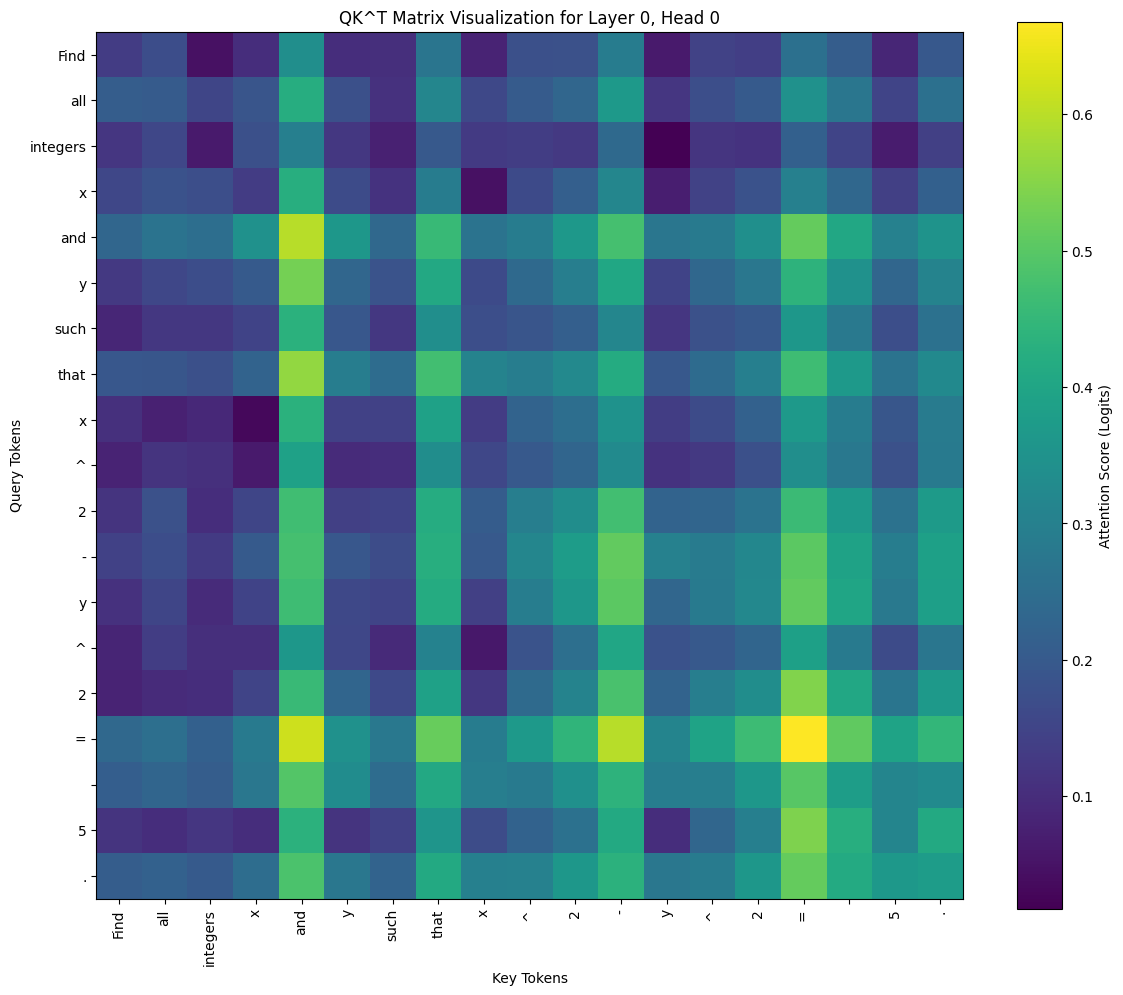

In [ ]:
example_text = "Find all integers x and y such that x^2 - y^2 = 5."

visualize_attention(model, tokenizer, example_text, 0)

### Exercise 3: Choose your own example text. Find **two** pairs of two distinct words with the highest attention values. Why do you think those two pairs have the highest attention values?

กำหนดประโยคภาษาอังกฤษ ดูว่าคำไหนมีค่าattentionสูงบ้าง  2คู่ +วิเคราะว่าไม2คู่นั้นถึงมี ค่าattention สูงบ้าง

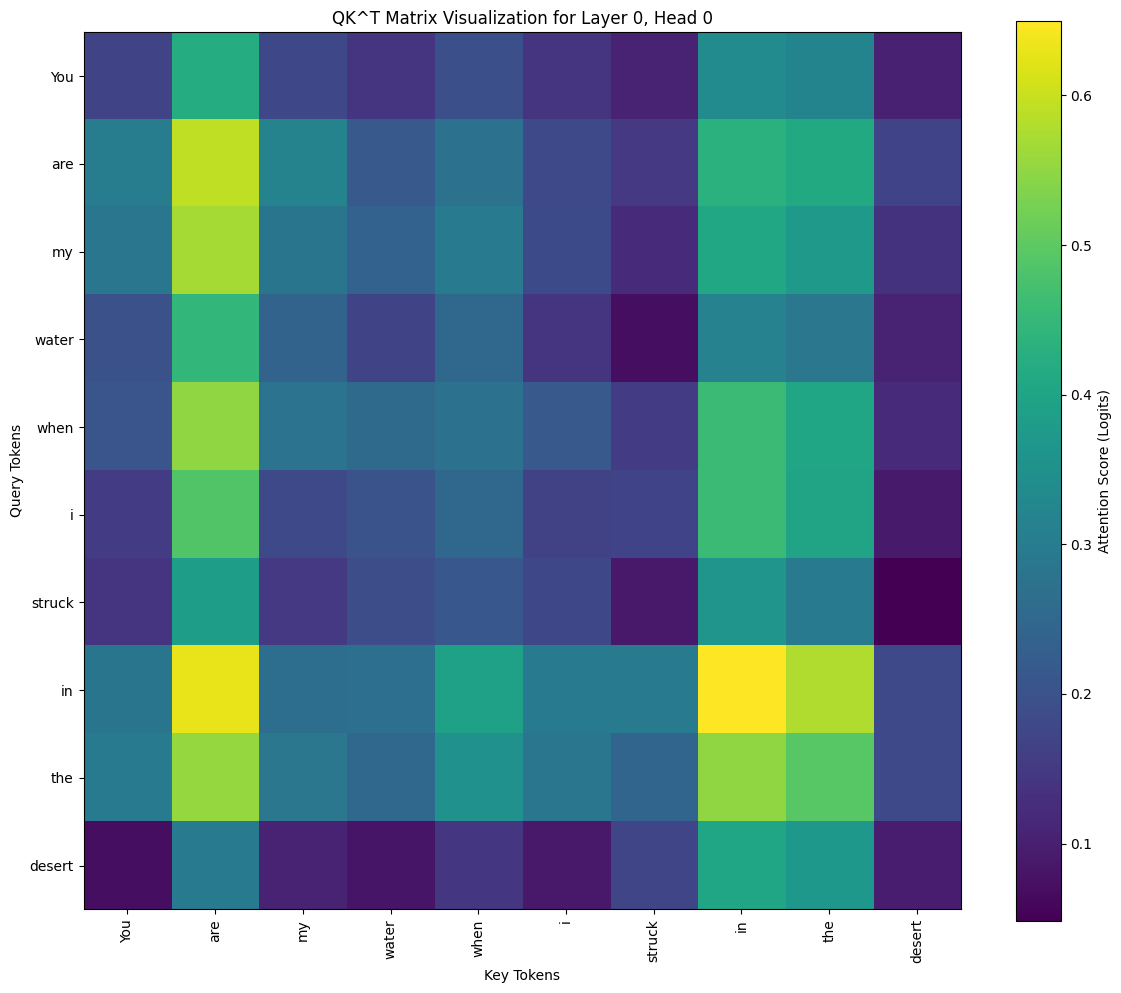

In [ ]:
### YOUR CODE HERE ###
example_text = "You are my water when i struck in the desert"

visualize_attention(model, tokenizer, example_text, 0)



**Answers to Exercise 3**

- คู่ in กับ are เพราะ are เป็นคำกริยาหลักของประโยค และ model พยายามเชื่อมความหมายของส่วนท้ายกลับไปหาคำหลักตรงกลาง
- คู่ in กับ the คิดว่าเนื่องจาก in article ของภาษาอังกฤษ in จะตามด้วยคำว่าthe  ค่าของ attention จึงมีค่าสูง

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

การเซฟmodelเพื่อจะได้ใช้ต่อในอนาคต ไม่ต้องrunใหม่

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False: # Pushing to HF Hub
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")
